In [ ]:
#data download from GEO 
# Euctopic and ectopic human endometrium (endometriosis)
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE11691


In [31]:
import GEOparse

# Replace 'GSE11691' with your GEO series ID
gse_id = 'GSE11691'
gse = GEOparse.get_GEO(geo=gse_id, destdir="./dbGSEdata")

29-Jul-2024 02:55:02 DEBUG utils - Directory ./dbGSEdata already exists. Skipping.
29-Jul-2024 02:55:02 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE11nnn/GSE11691/soft/GSE11691_family.soft.gz to ./dbGSEdata\GSE11691_family.soft.gz
100%|██████████████████████████████████████████████████████████████████████████████| 7.76M/7.76M [00:48<00:00, 169kB/s]
29-Jul-2024 02:55:52 DEBUG downloader - Size validation passed
29-Jul-2024 02:55:52 DEBUG downloader - Moving C:\Users\Sudeep\AppData\Local\Temp\tmp413koysq to D:\Genomics_research\dbGSEdata\GSE11691_family.soft.gz
29-Jul-2024 02:55:52 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE11nnn/GSE11691/soft/GSE11691_family.soft.gz
29-Jul-2024 02:55:52 INFO GEOparse - Parsing ./dbGSEdata\GSE11691_family.soft.gz: 
29-Jul-2024 02:55:52 DEBUG GEOparse - DATABASE: GeoMiame
29-Jul-2024 02:55:52 DEBUG GEOparse - SERIES: GSE11691
29-Jul-2024 02:55:52 DEBUG GEOparse - PLATFORM: GPL96
29-Jul-2024

In [32]:
import GEOparse

# Load the GEO dataset
gse = GEOparse.get_GEO(filepath="./dbGSEdata/GSE11691_family.soft.gz")

29-Jul-2024 02:56:22 INFO GEOparse - Parsing ./dbGSEdata/GSE11691_family.soft.gz: 
29-Jul-2024 02:56:22 DEBUG GEOparse - DATABASE: GeoMiame
29-Jul-2024 02:56:22 DEBUG GEOparse - SERIES: GSE11691
29-Jul-2024 02:56:22 DEBUG GEOparse - PLATFORM: GPL96
29-Jul-2024 02:56:25 DEBUG GEOparse - SAMPLE: GSM296875
29-Jul-2024 02:56:25 DEBUG GEOparse - SAMPLE: GSM296876
29-Jul-2024 02:56:25 DEBUG GEOparse - SAMPLE: GSM296877
29-Jul-2024 02:56:25 DEBUG GEOparse - SAMPLE: GSM296878
29-Jul-2024 02:56:25 DEBUG GEOparse - SAMPLE: GSM296879
29-Jul-2024 02:56:25 DEBUG GEOparse - SAMPLE: GSM296880
29-Jul-2024 02:56:25 DEBUG GEOparse - SAMPLE: GSM296881
29-Jul-2024 02:56:26 DEBUG GEOparse - SAMPLE: GSM296882
29-Jul-2024 02:56:26 DEBUG GEOparse - SAMPLE: GSM296883
29-Jul-2024 02:56:26 DEBUG GEOparse - SAMPLE: GSM296884
29-Jul-2024 02:56:26 DEBUG GEOparse - SAMPLE: GSM296885
29-Jul-2024 02:56:26 DEBUG GEOparse - SAMPLE: GSM296886
29-Jul-2024 02:56:26 DEBUG GEOparse - SAMPLE: GSM296887
29-Jul-2024 02:56:26 DE

In [39]:
import pandas as pd

# Extract samples and metadata
samples = gse.gsms
metadata = pd.DataFrame({
    sample: gse.gsms[sample].metadata
    for sample in gse.gsms.keys()
}).T

# Extract expression data (assuming it is stored in the table_rows attribute)
expression_data = pd.DataFrame({
    gsm: gse.gsms[gsm].table.set_index('ID_REF')['VALUE']
    for gsm in gse.gsms.keys()
})

print(expression_data)


                GSM296875  GSM296876  GSM296877  GSM296878  GSM296879  \
ID_REF                                                                  
AFFX-BioB-5_at      244.0      415.9      395.6      244.2      366.5   
AFFX-BioB-M_at      332.8      684.3      804.7      499.8      492.9   
AFFX-BioB-3_at      168.4      342.5      471.8      259.8      203.5   
AFFX-BioC-5_at      850.8     1515.4     1614.9     1108.2     1162.8   
AFFX-BioC-3_at      533.5     1160.0     1195.6      801.4      835.9   
...                   ...        ...        ...        ...        ...   
222380_s_at         297.3      205.4      313.4      201.3      214.0   
222381_at            45.9       83.0       65.9       43.4       62.5   
222382_x_at          40.7       35.6      102.7       56.3       45.9   
222383_s_at           7.5       10.7       25.2        6.5       12.7   
222384_at             8.4       21.3       12.6       37.7       61.8   

                GSM296880  GSM296881  GSM296882  G

In [36]:
# Check for missing values
missing_genes = expression_data.index[expression_data.isnull().any(axis=1)]
print("Missing genes:", missing_genes)


Missing genes: Index([], dtype='object', name='ID_REF')


In [37]:
# Option 1: Remove missing values
expression_data_clean = expression_data.dropna()
# print(expression_data_clean)
# Option 2: Fill missing values (e.g., with zero)
# expression_data_clean = expression_data.fillna(0)



In [40]:

import scanpy as sc

# Convert to AnnData
adata = sc.AnnData(X=expression_data_clean.T)

# Proceed with analysis
# Quality control
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Scale the data
sc.pp.scale(adata, max_value=10)

# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

# Compute UMAP
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=10)
sc.tl.umap(adata)



C:\Users\Sudeep\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\preprocessing\_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\Sudeep\AppData\Roaming\Python\Python39\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


Available genes for plotting: Index(['AFFX-BioB-5_at', 'AFFX-BioB-M_at', 'AFFX-BioB-3_at', 'AFFX-BioC-5_at',
       'AFFX-BioC-3_at'],
      dtype='object', name='ID_REF')


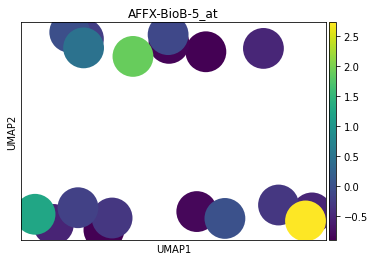

In [41]:
# Use available gene that is present
available_genes = adata.var_names[:5]  # List the first five available genes
print("Available genes for plotting:", available_genes)

# Plot using an available gene
sc.pl.umap(adata, color=available_genes[0])  # Use the first available gene


C:\Users\Sudeep\AppData\Local\Temp/ipykernel_2832/2832648544.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)


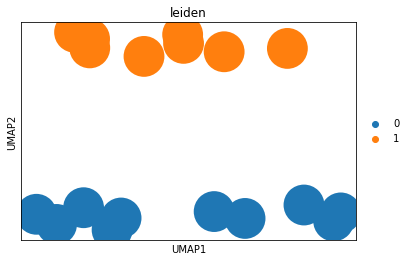

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


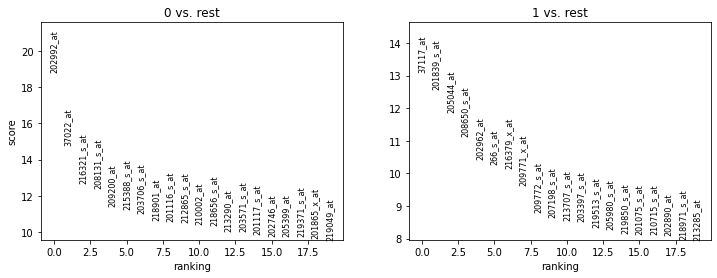

In [42]:
# Plot clusters instead of specific genes if needed

# Cluster the data
sc.tl.leiden(adata, resolution=0.5)

# Plot clusters
sc.pl.umap(adata, color='leiden')

# Find marker genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

# Plot the top markers
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


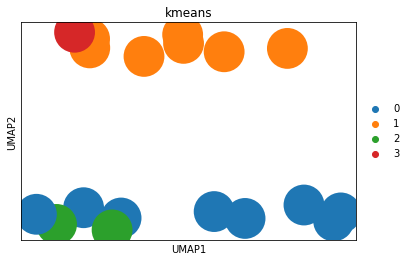

ValueError: Could not calculate statistics for groups 3 since they only contain one sample.

In [56]:
# K-means Clustering
from sklearn.cluster import KMeans

# Run K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(adata.X)

# Add K-means clusters to adata
adata.obs['kmeans'] = kmeans.labels_.astype(str)

# Plot clusters
sc.pl.umap(adata, color='kmeans')

# Find marker genes for K-means clusters
sc.tl.rank_genes_groups(adata, 'kmeans', method='t-test')

# Plot the top markers
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


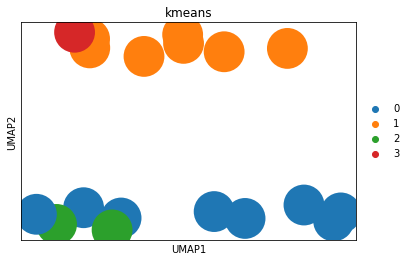

kmeans
0    8
1    7
2    2
3    1
Name: count, dtype: int64


In [52]:
# adjusting the number of clusters or removing clusters with too few samples before ranking genes.

# Run K-means clustering with fewer clusters
kmeans = KMeans(n_clusters=4, random_state=0).fit(adata.X)

# Add K-means clusters to adata
adata.obs['kmeans'] = kmeans.labels_.astype(str)

# Plot clusters
sc.pl.umap(adata, color='kmeans')

# Check cluster sizes
print(adata.obs['kmeans'].value_counts())


C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


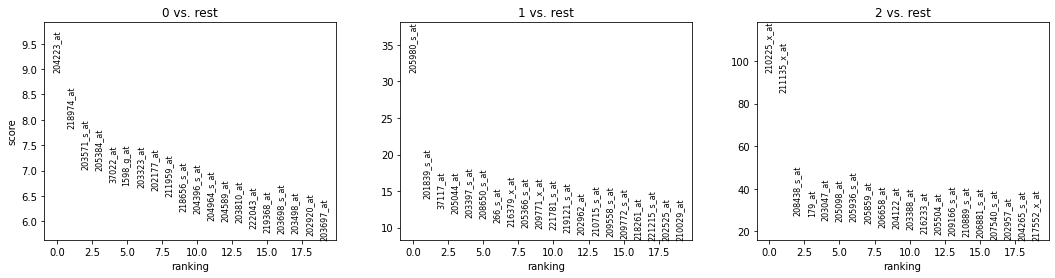

In [53]:
# Filter out clusters with fewer than a threshold (e.g., 5 samples)
valid_clusters = adata.obs['kmeans'].value_counts()[adata.obs['kmeans'].value_counts() > 1].index
adata_filtered = adata[adata.obs['kmeans'].isin(valid_clusters)].copy()

# Find marker genes for valid clusters
sc.tl.rank_genes_groups(adata_filtered, 'kmeans', method='t-test')

# Plot the top markers
sc.pl.rank_genes_groups(adata_filtered, n_genes=20, sharey=False)


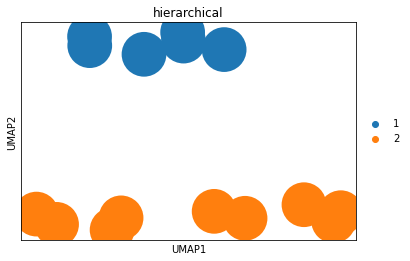

C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
C:\ProgramData\Anaconda3\lib\site-packages\scanpy\tools\_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


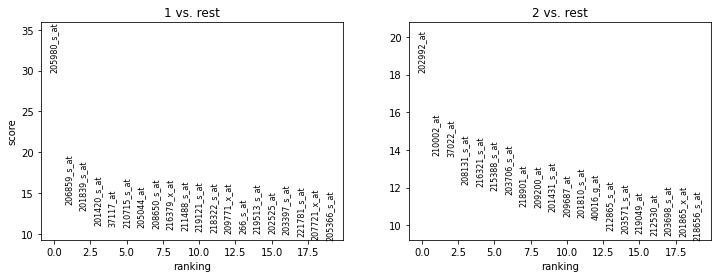

In [64]:
# Hierarchical Clustering
# Define a threshold for minimum cluster size
min_cluster_size = 4

# Filter clusters with enough samples
valid_clusters = adata.obs['hierarchical'].value_counts()[
    adata.obs['hierarchical'].value_counts() >= min_cluster_size
].index

# Subset the data
adata_filtered = adata[adata.obs['hierarchical'].isin(valid_clusters)].copy()

# Convert to categorical
adata_filtered.obs['hierarchical'] = adata_filtered.obs['hierarchical'].astype('category')

# Plot clusters
sc.pl.umap(adata_filtered, color='hierarchical')

# Find marker genes for valid clusters
sc.tl.rank_genes_groups(adata_filtered, 'hierarchical', method='t-test')

# Plot the top markers
sc.pl.rank_genes_groups(adata_filtered, n_genes=20, sharey=False)


